In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhuvana309","key":"32c563b54e0c12258033d2f7c9fc0128"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 86% 13.0M/15.1M [00:01<00:00, 14.6MB/s]
100% 15.1M/15.1M [00:01<00:00, 9.00MB/s]


In [ ]:
!unzip brain-mri-images-for-brain-tumor-detection.zip -d ./MRI_BRAIN


Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/1 no.jpeg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/10 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/11 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/12 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/13 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/14 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/15 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/17 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/18 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/19 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/2 no.jpeg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/20 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/21 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/22 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_dataset/no/23 no.jpg  
  inflating: ./MRI_BRAIN/brain_tumor_datase

In [ ]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf

# Function to preprocess MRI images
def preprocess_mri_jpg(file_path, target_shape=(128, 128, 64)):
    file_path = file_path.numpy().decode('utf-8')
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (target_shape[0], target_shape[1]))
    img = img.astype(np.float32) / 255.0
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dimension
    return volume

# Function to create a TensorFlow dataset
def create_dataset(tumor_dir, no_tumor_dir, batch_size=8):
    tumor_files = glob.glob(os.path.join(tumor_dir, "*.jpg"))
    no_tumor_files = glob.glob(os.path.join(no_tumor_dir, "*.jpg"))

    file_paths = np.array(tumor_files + no_tumor_files)
    labels = np.array([1] * len(tumor_files) + [0] * len(no_tumor_files))

    indices = np.arange(len(file_paths))
    np.random.shuffle(indices)

    file_paths, labels = file_paths[indices], labels[indices]

    def load_and_preprocess(file_path, label):
        volume = tf.py_function(func=preprocess_mri_jpg, inp=[file_path], Tout=tf.float32)
        volume.set_shape((128, 128, 64, 1))
        return volume, label

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# 3D CNN Model
def build_3d_cnn(input_shape=(128, 128, 64, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling3D((2, 2, 2))(x)
    x = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling3D((2, 2, 2))(x)
    x = tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling3D((2, 2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

if __name__ == "__main__":
    tumor_dir = "./MRI_BRAIN/yes"  # Change to actual path
    no_tumor_dir = "./MRI_BRAIN/no"  # Change to actual path
    batch_size = 8

    dataset = create_dataset(tumor_dir, no_tumor_dir, batch_size)
    model = build_3d_cnn()

    model.fit(dataset, epochs=10)
    model.save("brain_tumor_model.h5")



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 667ms/step - accuracy: 0.6626 - loss: 0.7003
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.7452 - loss: 0.5152
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.7614 - loss: 0.4728
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.7810 - loss: 0.4205
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.8016 - loss: 0.3704
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.8396 - loss: 0.3238
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.8857 - loss: 0.2323
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.9154 - loss: 0.1907
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.9492 - loss: 0.1193
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9818 - loss: 0.0962


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files  # For file upload in Google Colab

# Upload an MRI image
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]  # Get uploaded file name

# Check if file is uploaded successfully
if os.path.exists(test_image_path):
    print("Test image uploaded:", test_image_path)
else:
    print("❌ Upload failed! Please try again.")

# Function to preprocess the new image
def preprocess_image(image_path, target_shape=(128, 128, 64)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img = cv2.resize(img, (target_shape[0], target_shape[1]))  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create a 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dim
    volume = np.expand_dims(volume, axis=0)  # Add batch dim
    return volume

# Load trained model
model_path = "/content/brain_tumor_model.h5"  # Adjust path if needed
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    print("Model file not found! Train the model first.")
    exit()

# Predict Tumor
test_image = preprocess_image(test_image_path)
prediction = model.predict(test_image)[0][0]

# Interpret result
tumor_present = 1 if prediction >= 0.5 else 0
print("Tumor Detected (1)" if tumor_present else "No Tumor Detected (0)")


Saving 2 no.jpeg to 2 no.jpeg
Test image uploaded: 2 no.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
No Tumor Detected (0)


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files  # For file upload in Google Colab

# Upload an MRI image
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]  # Get uploaded file name

# Check if file is uploaded successfully
if os.path.exists(test_image_path):
    print("Test image uploaded:", test_image_path)
else:
    print("❌ Upload failed! Please try again.")

# Function to preprocess the new image
def preprocess_image(image_path, target_shape=(128, 128, 64)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img = cv2.resize(img, (target_shape[0], target_shape[1]))  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create a 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dim
    volume = np.expand_dims(volume, axis=0)  # Add batch dim
    return volume

# Load trained model
model_path = "/content/brain_tumor_model.h5"  # Adjust path if needed
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    print("Model file not found! Train the model first.")
    exit()

# Predict Tumor
test_image = preprocess_image(test_image_path)
prediction = model.predict(test_image)[0][0]

# Interpret result
tumor_present = 1 if prediction >= 0.5 else 0
print("Tumor Detected (1)" if tumor_present else "No Tumor Detected (0)")


Saving Y2.jpg to Y2.jpg
Test image uploaded: Y2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Tumor Detected (1)


Saving 25 no.jpg to 25 no.jpg
Test image uploaded: 25 no.jpg


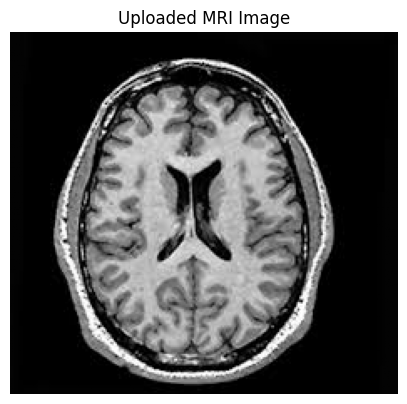

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
No Tumor Detected (0)


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files  # For file upload in Google Colab

# Upload an MRI image
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]  # Get uploaded file name

# Check if file is uploaded successfully
if os.path.exists(test_image_path):
    print("Test image uploaded:", test_image_path)
else:
    print("❌ Upload failed! Please try again.")

# Function to preprocess the new image and display it
def preprocess_image(image_path, target_shape=(128, 128, 64)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

    # Display the original image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title("Uploaded MRI Image")
    plt.axis("off")
    plt.show()

    img = cv2.resize(img, (target_shape[0], target_shape[1]))  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create a 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dim
    volume = np.expand_dims(volume, axis=0)  # Add batch dim
    return volume

# Load trained model
model_path = "/content/brain_tumor_model.h5"  # Adjust path if needed
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    print("Model file not found! Train the model first.")
    exit()

# Predict Tumor
test_image = preprocess_image(test_image_path)
prediction = model.predict(test_image)[0][0]

# Interpret result
tumor_present = 1 if prediction >= 0.5 else 0
print("Tumor Detected (1)" if tumor_present else "No Tumor Detected (0)")


In [ ]:
import os  # Import the os module
import tensorflow as tf # Import tensorflow
import tensorflow as tf
import numpy as np
import cv2 # Import the OpenCV library
import os
import glob

# Function to preprocess the new image and predict
def predict_new_image(image_path, model, target_shape=(128, 128, 64)):
    """
    Preprocesses a new image and predicts tumor probability using the provided model.

    Args:
        image_path (str): Path to the new image file.
        model (tf.keras.Model): The trained Keras model.
        target_shape (tuple): Target shape for image resizing (default: (128, 128, 64)).

    Returns:
        float: The predicted tumor probability.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img = cv2.resize(img, (target_shape[0], target_shape[1]))  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create a 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dim
    volume = np.expand_dims(volume, axis=0)  # Add batch dim

    prediction = model.predict(volume)[0][0]  # Predict using the model
    return prediction

test_image_path = '/content/Y2.jpg'

if os.path.exists(test_image_path):
    print("Test image file exists!")
else:
    print("Test image file NOT found! Please check the path.")


# Load the saved model
model = tf.keras.models.load_model('/content/brain_tumor_model.h5') # Call load_model using tf

# Predict tumor probability for the new image
tumor_probability = predict_new_image(test_image_path, model)

if tumor_probability is not None:
    print("Tumor Probability for new image: {:.4f}".format(tumor_probability))

Test image file exists!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Tumor Probability for new image: 0.9552


In [ ]:
+import os  # Import the os module
import tensorflow as tf # Import tensorflow
import tensorflow as tf
import numpy as np
import cv2 # Import the OpenCV library
import os
import glob

# Function to preprocess the new image and predict
def predict_new_image(image_path, model, target_shape=(128, 128, 64)):
    """
    Preprocesses a new image and predicts tumor probability using the provided model.

    Args:
        image_path (str): Path to the new image file.
        model (tf.keras.Model): The trained Keras model.
        target_shape (tuple): Target shape for image resizing (default: (128, 128, 64)).

    Returns:
        float: The predicted tumor probability.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img = cv2.resize(img, (target_shape[0], target_shape[1]))  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    volume = np.stack([img] * target_shape[2], axis=-1)  # Create a 3D volume
    volume = np.expand_dims(volume, axis=-1)  # Add channel dim
    volume = np.expand_dims(volume, axis=0)  # Add batch dim

    prediction = model.predict(volume)[0][0]  # Predict using the model
    return prediction

test_image_path = '/content/25 no.jpg'

if os.path.exists(test_image_path):
    print("Test image file exists!")
else:
    print("Test image file NOT found! Please check the path.")


# Load the saved model
model = tf.keras.models.load_model('/content/brain_tumor_model.h5') # Call load_model using tf

# Predict tumor probability for the new image
tumor_probability = predict_new_image(test_image_path, model)

if tumor_probability is not None:
    print("Tumor Probability for new image: {:.4f}".format(tumor_probability))

Test image file exists!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Tumor Probability for new image: 0.0001
